In [31]:
import geopandas as gpd
from shapely.geometry import box


"Code shows what data the Dallas parcels contains" 

# Load the parcel dataset
parcels = gpd.read_file("/Users/jimnguyen/IRMII/SCS_API/parcel_data/shp/stratmap24-landparcels_48113_dallas_202407.dbf")

print("DATASET OVERVIEW")
print(f"Total rows: {len(parcels)}")
print(f"Total columns: {len(parcels.columns)}")

print("ALL COLUMN NAMES + DATA TYPES")
for i, col in enumerate(parcels.columns, 1):
    print(f"{i:2d}. {col}")
    print(parcels.dtypes[col])



DATASET OVERVIEW
Total rows: 693520
Total columns: 38
ALL COLUMN NAMES + DATA TYPES
 1. Prop_ID
object
 2. GEO_ID
object
 3. OWNER_NAME
object
 4. NAME_CARE
object
 5. LEGAL_AREA
object
 6. LGL_AREA_U
object
 7. GIS_AREA
float64
 8. GIS_AREA_U
object
 9. LEGAL_DESC
object
10. STAT_LAND_
object
11. LOC_LAND_U
object
12. LAND_VALUE
float64
13. IMP_VALUE
float64
14. MKT_VALUE
float64
15. SITUS_ADDR
object
16. SITUS_NUM
object
17. SITUS_STRE
object
18. SITUS_ST_1
object
19. SITUS_ST_2
object
20. SITUS_CITY
object
21. SITUS_STAT
object
22. SITUS_ZIP
object
23. MAIL_ADDR
object
24. MAIL_LINE1
object
25. MAIL_LINE2
object
26. MAIL_CITY
object
27. MAIL_STAT
object
28. MAIL_ZIP
object
29. SOURCE
object
30. DATE_ACQ
int64
31. FIPS
object
32. COUNTY
object
33. TAX_YEAR
int64
34. YEAR_BUILT
object
35. OBJECTID
int64
36. Shape_Leng
float64
37. Shape_Area
float64
38. geometry
geometry


In [ ]:
import geopandas as gpd
from shapely.geometry import box

"Code uses Microsoft Texas spatial data to "
"return Dallas County only."

#From microsoft spatial data, filter to Dallas County

gdf = gpd.read_file("/Users/jimnguyen/IRMII/SCS_API/dallas_property_analysis/Texas.geojson")

#dallas_county
minx, miny = -97.027500, 32.538500  # bottom-left
maxx, maxy = -96.449000, 33.016500  # top-right
dallas_bbox = box(minx, miny, maxx, maxy)

gdf_filtered = gdf[gdf.geometry.intersects(dallas_bbox)]
gdf_filtered.to_file("Dallas.geojson", driver="GeoJSON")

DataSourceError: Texas.geojson: No such file or directory

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box, Polygon, Point, MultiPolygon, LineString

"Code uses Dallas parcels + Microsoft's GlobalMLBuildingFootprints. "
"Code returns Market Value, Year Built, and Geometry for Dallas County parcels."
"*** Dallas parcels have only 11% of build dates***   " 

# Load datasets
print("Loading datasets...")

#Set both paths below to your data files
parcels = gpd.read_file("/Users/jacksonmorrissett/Projects/Research/Dallas-housing/shp/stratmap24-landparcels_48113_dallas_202407.dbf")
microsoft = gpd.read_file("/Users/jacksonmorrissett/Projects/Research/Dallas.geojson")

def round_coordinates(geom, precision=6):
    """Round coordinates to specified decimal places"""
    if geom is None or geom.is_empty:
        return geom
        
    if geom.geom_type == 'Polygon':
        exterior = [(round(x, precision), round(y, precision)) for x, y in geom.exterior.coords]
        holes = []
        for interior in geom.interiors:
            hole_coords = [(round(x, precision), round(y, precision)) for x, y in interior.coords]
            holes.append(hole_coords)
        return Polygon(exterior, holes)
        
    elif geom.geom_type == 'Point':
        return Point(round(geom.x, precision), round(geom.y, precision))
        
    elif geom.geom_type == 'LineString':
        coords = [(round(x, precision), round(y, precision)) for x, y in geom.coords]
        return LineString(coords)
        
    elif geom.geom_type == 'MultiPolygon':
        polygons = []
        for poly in geom.geoms:
            polygons.append(round_coordinates(poly, precision))
        return MultiPolygon(polygons)
        
    return geom

# Ensure coordinates are same format
parcels_latlon = parcels.to_crs(epsg=4326)
bounds_latlon = microsoft.to_crs(epsg=4326)
parcels_latlon['geometry'] = parcels_latlon['geometry'].apply(lambda geom: round_coordinates(geom, 6))
bounds_latlon['geometry'] = bounds_latlon['geometry'].apply(lambda geom: round_coordinates(geom, 6))

# Ensure parcels are only within dallas county
dallas_bbox = box(-97.027500, 32.538500, -96.449000, 33.016500)
parcels_filtered = parcels_latlon[parcels_latlon.geometry.intersects(dallas_bbox)]

# Combine the two
print("combining datasets...")
gdf_joined = gpd.sjoin(bounds_latlon, parcels_filtered, how="left", predicate="intersects")

# Clean year built data
if 'YEAR_BUILT' in gdf_joined.columns:
    gdf_joined['YEAR_BUILT'] = pd.to_numeric(gdf_joined['YEAR_BUILT'], errors='coerce')

# Keep geometry (coordinates), market value, and build date.
new_cols = ['geometry']
if 'MKT_VALUE' in gdf_joined.columns:
    new_cols.append('MKT_VALUE')
if 'YEAR_BUILT' in gdf_joined.columns:
    new_cols.append('YEAR_BUILT')

# Create final result with only the requested data
result = gdf_joined[new_cols].copy()

# Saveing the result
result.to_file("dallas_3var.geojson", driver="GeoJSON")
print(f"Results saved with {len(result)} records")
print(f"Columns: {result.columns.tolist()}")

Loading data...
Found 957253 features
Null/invalid year_built values: 270982
Null/invalid market_value values: 0
After cleaning: 685580 valid records
Year range in data: 0 - 9999
Special year codes found:
  Year 1000: 559753 properties
  Year 9999: 50891 properties

Data Statistics:
Total properties: 685580
Year range: 1825 - 2025


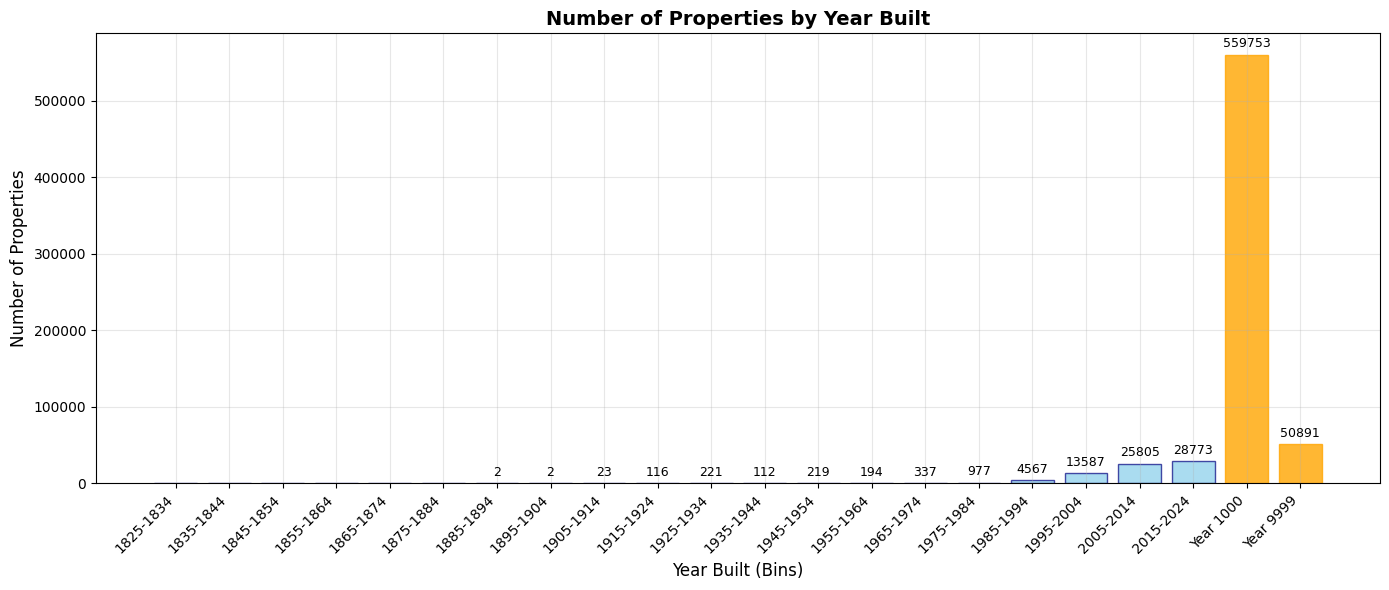

In [23]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

"Code graphs a histogram of "
"Dallas parcels (year_built + market value) "
"and microsoft location data" 

# Adjustable parameters
file_path = "dallas_3var.geojson"
min_year = 1825
max_year = 2025
bin_size = 10

def load_geojson(file_path):
    """Load GeoJSON file and extract property data"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    properties = []
    for feature in data['features']:
        props = feature['properties']
        properties.append({
            'year_built': props.get('YEAR_BUILT'),
            'market_value': props.get('MKT_VALUE')
        })
    
    return properties

def clean_data(properties):
    """Clean and validate the data"""
    null_market = 0
    null_year = 0
    cleaned_data = []
    
    for prop in properties:
        try:
            year_built = int(prop['year_built'])
        except (ValueError, TypeError):
            null_year += 1
            continue
        
        try:
            market_value = float(prop['market_value'])
            if market_value <= 0:
                continue
        except (ValueError, TypeError):
            null_market += 1
            continue
        
        cleaned_data.append({
            'year_built': year_built,
            'market_value': market_value
        })
    
    return cleaned_data, null_market, null_year

def create_bins(data, bin_size, min_year, max_year):
    """Create histogram data with adjustable bins"""
    
    # Handle years 1000 and 9999
    special_years = defaultdict(int)
    regular_data = []
    
    for item in data:
        year = item['year_built']
        if year in [1000, 9999]:
            special_years[year] += 1
        else:
            regular_data.append(item)
    
    # Create bins from min_year to max_year
    bins = list(range(min_year, max_year + bin_size, bin_size))
    bin_counts = defaultdict(int)
    
    # Group regular data by bins
    for item in regular_data:
        year = item['year_built']
        if year < min_year or year >= max_year:
            continue
        
        bin_index = (year - min_year) // bin_size
        if bin_index < len(bins) - 1:
            bin_start = bins[bin_index]
            bin_counts[bin_start] += 1

    bin_labels = []
    bin_values = []
    
    for i in range(len(bins) - 1):
        bin_start = bins[i]
        bin_end = bins[i + 1]
        count = bin_counts[bin_start]
        
        bin_labels.append(f"{bin_start}-{bin_end-1}")
        bin_values.append(count)
    
    # Add special years as separate columns at the end
    for year in sorted(special_years.keys()):
        bin_labels.append(f"Year {year}")
        bin_values.append(special_years[year])
    
    return bin_labels, bin_values

def plot_count_by_year(file_path, bin_size, min_year, max_year):
    """Create a bar chart showing number of properties by year built with bins"""
    
    print("Loading data...")
    properties = load_geojson(file_path)
    cleaned_data, null_market, null_year = clean_data(properties)

    #Relay information about the data
    print(f"Found {len(properties)} features")
    print(f"Null/invalid year_built values: {null_year}")
    print(f"Null/invalid market_value values: {null_market}")
    print(f"After cleaning: {len(cleaned_data)} valid records")
    
    if len(cleaned_data) == 0:
        print("No data")
        return
    
    # Show year distribution
    years = [item['year_built'] for item in cleaned_data]
    print(f"Year range in data: {min(years)} - {max(years)}")
    
    # Count special years
    special_year_counts = {}
    for year in [1000, 9999]:
        count = years.count(year)
        if count > 0:
            special_year_counts[year] = count
    
    if special_year_counts:
        print("Special year codes found:")
        for year, count in special_year_counts.items():
            print(f"  Year {year}: {count} properties")

    # Create bins
    bin_labels, bin_values = create_bins(cleaned_data, bin_size, min_year, max_year)
    
    # Create the plot
    plt.figure(figsize=(14, 6))
    
    # Create bar chart
    bars = plt.bar(range(len(bin_labels)), bin_values, alpha=0.7, color='skyblue', edgecolor='navy')
    
    # Showcase special years with different colors
    for i, label in enumerate(bin_labels):
        if 'Year 1000' in label or 'Year 9999' in label:
            bars[i].set_color('orange')
            bars[i].set_alpha(0.8)
    
    # Add value labels on top of each bar
    for i, value in enumerate(bin_values):
        if value > 0:
            plt.text(i, value + max(bin_values) * 0.01, str(value), 
                    ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Year Built (Bins)', fontsize=12)
    plt.ylabel('Number of Properties', fontsize=12)
    plt.title('Number of Properties by Year Built', fontsize=14, fontweight='bold')
    
    plt.xticks(range(len(bin_labels)), bin_labels, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print statistics
    print("\nData Statistics:")
    print(f"Total properties: {len(cleaned_data)}")
    print(f"Year range: {min_year} - {max_year}")
    
    plt.show()

plot_count_by_year(file_path, bin_size, min_year, max_year)

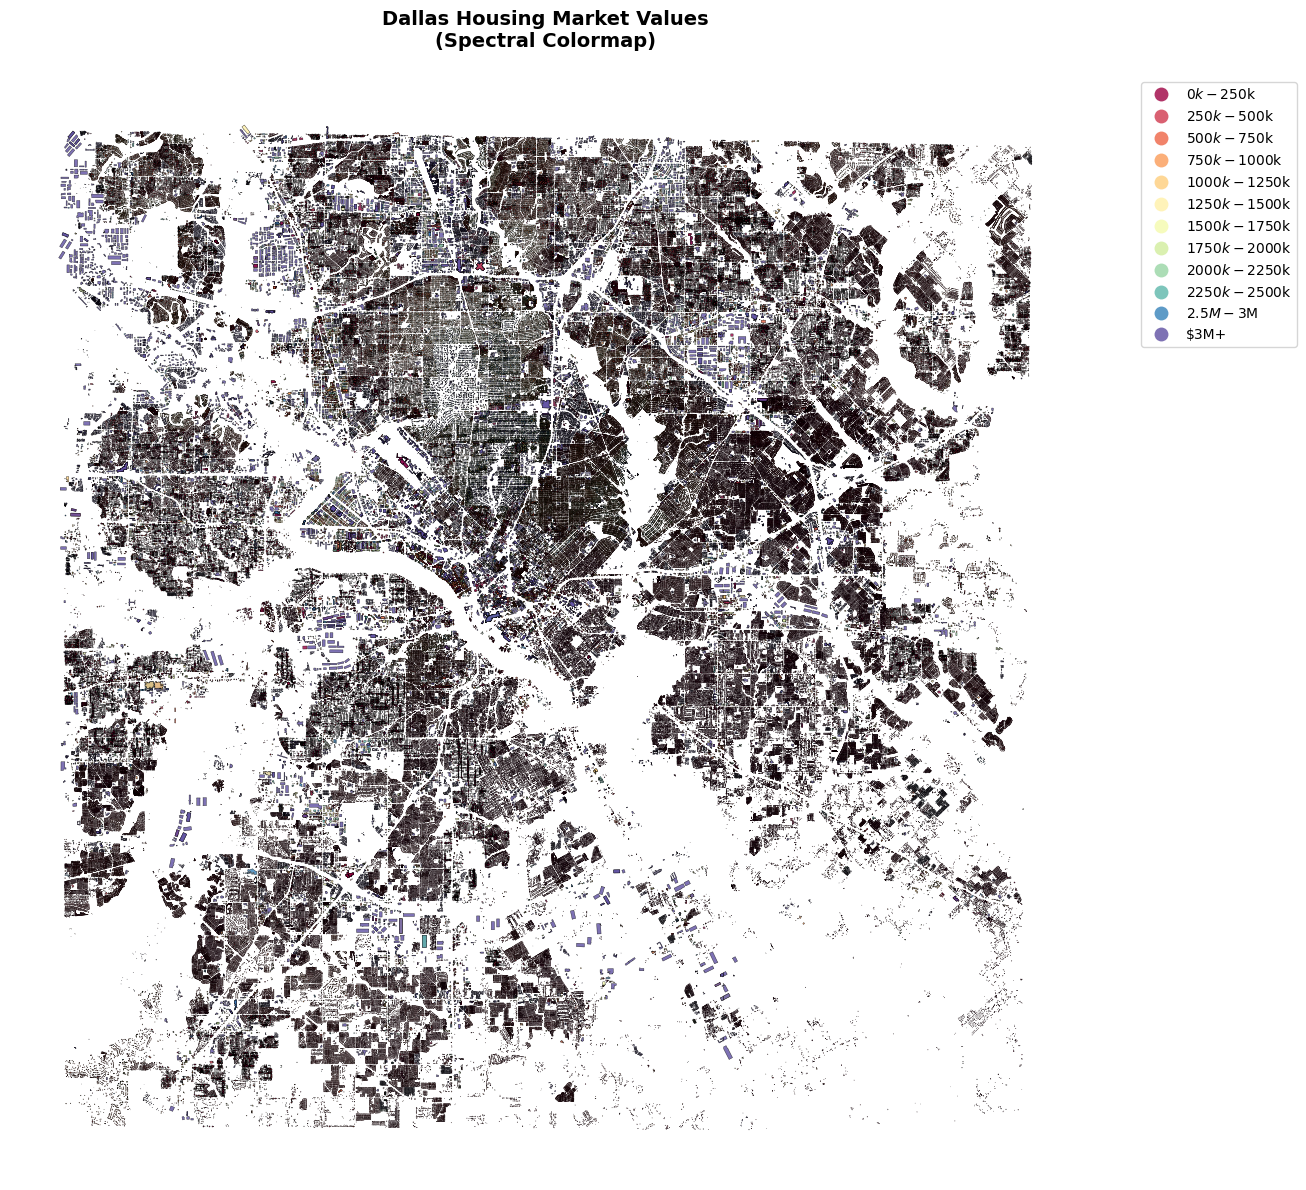

Market Value Group Distribution:
Market_Group
$0k-$250k        348305
$250k-$500k      316099
$500k-$750k       75032
$750k-$1000k      26793
$1000k-$1250k     14132
$1250k-$1500k     10091
$1500k-$1750k      7279
$1750k-$2000k      5432
$2000k-$2250k      4481
$2250k-$2500k      3765
$2.5M-$3M          5595
$3M+              55907
Name: count, dtype: int64
Total properties: 957253
Average market value: $2,056,895
Median market value: $284,340


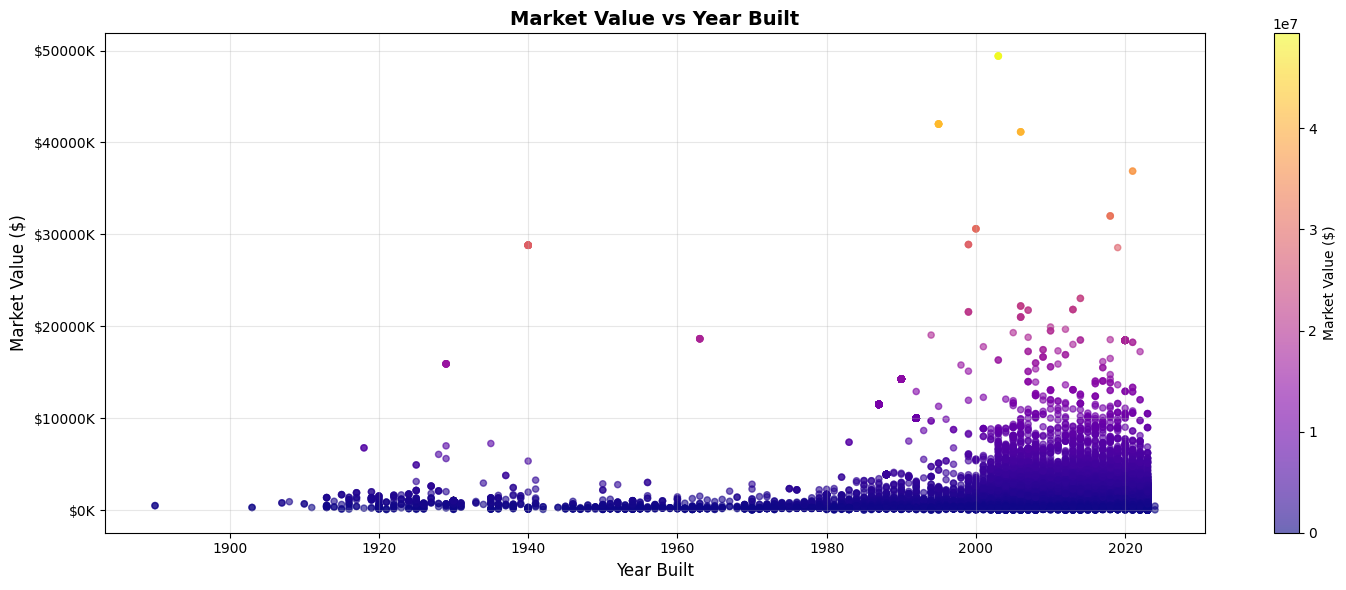

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

"Code visualizes Dallas housing market values "
"with custom market value groups and scatter plot"
"to confirm that dallas_3var.geojson has the correct locations"

# Load your Dallas data
dallas = gpd.read_file("dallas_3var.geojson")

# Function to create market value groups with special 3M+ category
def create_market_groups(df, group_size=250000, cutoff_2_5m=2500000, cutoff_3m=3000000):
    """Create market value groups: $250k intervals up to 2.5M, then 3M+ group"""
    
    # Create bins from 0 to 2.5M in 250k increments
    bins = list(range(0, cutoff_2_5m + group_size, group_size))
    
    # Add the 3M+ category
    bins.append(cutoff_3m)
    bins.append(float('inf'))  # For everything above 3M
    
    # Create labels for each bin
    labels = []
    
    # Labels for 0 to 2.5M in 250k increments
    for i in range(len(bins)-3): 
        start = bins[i] // 1000  # Convert to thousands
        end = bins[i+1] // 1000
        labels.append(f'${start}k-${end}k')
    
    # Add labels for the higher ranges
    labels.append('$2.5M-$3M')
    labels.append('$3M+')
    
    # Create categorical column
    df['Market_Group'] = pd.cut(df['MKT_VALUE'], bins=bins, labels=labels, include_lowest=True)
    
    return df, bins, labels

# Apply custom grouping
dallas, bins, labels = create_market_groups(dallas, 250000)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

# Plot with Spectral colormap
dallas.plot(column='Market_Group',
            edgecolor='black',
            linewidth=0.3,
            alpha=0.8,
            legend=True,
            legend_kwds={"bbox_to_anchor": (1.05, 1),
                        "loc": 'upper left'},
            ax=ax,
            cmap='Spectral')

ax.set_title('Dallas Housing Market Values\n(Spectral Colormap)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Print data
print("Market Value Group Distribution:")
print(dallas['Market_Group'].value_counts().sort_index())
print(f"Total properties: {len(dallas)}")
print(f"Average market value: ${dallas['MKT_VALUE'].mean():,.0f}")
print(f"Median market value: ${dallas['MKT_VALUE'].median():,.0f}")

# Create scatter plot of Market Value vs Year Built
fig, ax = plt.subplots(figsize=(15, 6))

# Remove any invalid year values
dallas_clean = dallas[(dallas['YEAR_BUILT'] >= 1800) & (dallas['YEAR_BUILT'] <= 2024)]

# Scatter plot of Market Value distribution by Year Built 
scatter = ax.scatter(dallas_clean['YEAR_BUILT'], dallas_clean['MKT_VALUE'], 
                     c=dallas_clean['MKT_VALUE'], cmap='plasma', alpha=0.6, s=20)
ax.set_xlabel('Year Built', fontsize=12)
ax.set_ylabel('Market Value ($)', fontsize=12)
ax.set_title('Market Value vs Year Built', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add colorbar
plt.colorbar(scatter, ax=ax, label='Market Value ($)')

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

In [25]:
# Analyze market value distribution to understand color mapping issues
print("Market Value Statistics:")
print(f"Min value: ${dallas['MKT_VALUE'].min():,.0f}")
print(f"Max value: ${dallas['MKT_VALUE'].max():,.0f}")
print(f"25th percentile: ${dallas['MKT_VALUE'].quantile(0.25):,.0f}")
print(f"50th percentile (median): ${dallas['MKT_VALUE'].quantile(0.5):,.0f}")
print(f"75th percentile: ${dallas['MKT_VALUE'].quantile(0.75):,.0f}")
print(f"95th percentile: ${dallas['MKT_VALUE'].quantile(0.95):,.0f}")
print(f"99th percentile: ${dallas['MKT_VALUE'].quantile(0.99):,.0f}")

print("\nMarket Group Distribution (detailed):")
group_counts = dallas['Market_Group'].value_counts().sort_index()
for group, count in group_counts.items():
    percentage = (count / len(dallas)) * 100
    print(f"{group}: {count:,} properties ({percentage:.1f}%)")

print(f"\nProperties with null Market_Group: {dallas['Market_Group'].isnull().sum()}")
print(f"Properties with null MKT_VALUE: {dallas['MKT_VALUE'].isnull().sum()}")
print(f"Properties with MKT_VALUE = 0: {(dallas['MKT_VALUE'] == 0).sum()}")

Market Value Statistics:
Min value: $0
Max value: $999,999,950
25th percentile: $204,990
50th percentile (median): $284,340
75th percentile: $481,890
95th percentile: $5,281,010
99th percentile: $36,300,000

Market Group Distribution (detailed):
$0k-$250k: 348,305 properties (36.4%)
$250k-$500k: 316,099 properties (33.0%)
$500k-$750k: 75,032 properties (7.8%)
$750k-$1000k: 26,793 properties (2.8%)
$1000k-$1250k: 14,132 properties (1.5%)
$1250k-$1500k: 10,091 properties (1.1%)
$1500k-$1750k: 7,279 properties (0.8%)
$1750k-$2000k: 5,432 properties (0.6%)
$2000k-$2250k: 4,481 properties (0.5%)
$2250k-$2500k: 3,765 properties (0.4%)
$2.5M-$3M: 5,595 properties (0.6%)
$3M+: 55,907 properties (5.8%)

Properties with null Market_Group: 84342
Properties with null MKT_VALUE: 84342
Properties with MKT_VALUE = 0: 8570


Creating improved visualizations...
Valid properties for visualization: 864,341 (from 957,253 total)

Quantile-based Market Value Groups:
$0k-$165k: 108,056 properties (12.5%)
$165k-$207k: 108,035 properties (12.5%)
$207k-$245k: 108,043 properties (12.5%)
$245k-$286k: 108,061 properties (12.5%)
$286k-$352k: 108,021 properties (12.5%)
$352k-$486k: 108,043 properties (12.5%)
$486k-$984k: 108,039 properties (12.5%)
$984k-$1000.0M: 108,043 properties (12.5%)


/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_17864/2249374933.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(dollar_labels)


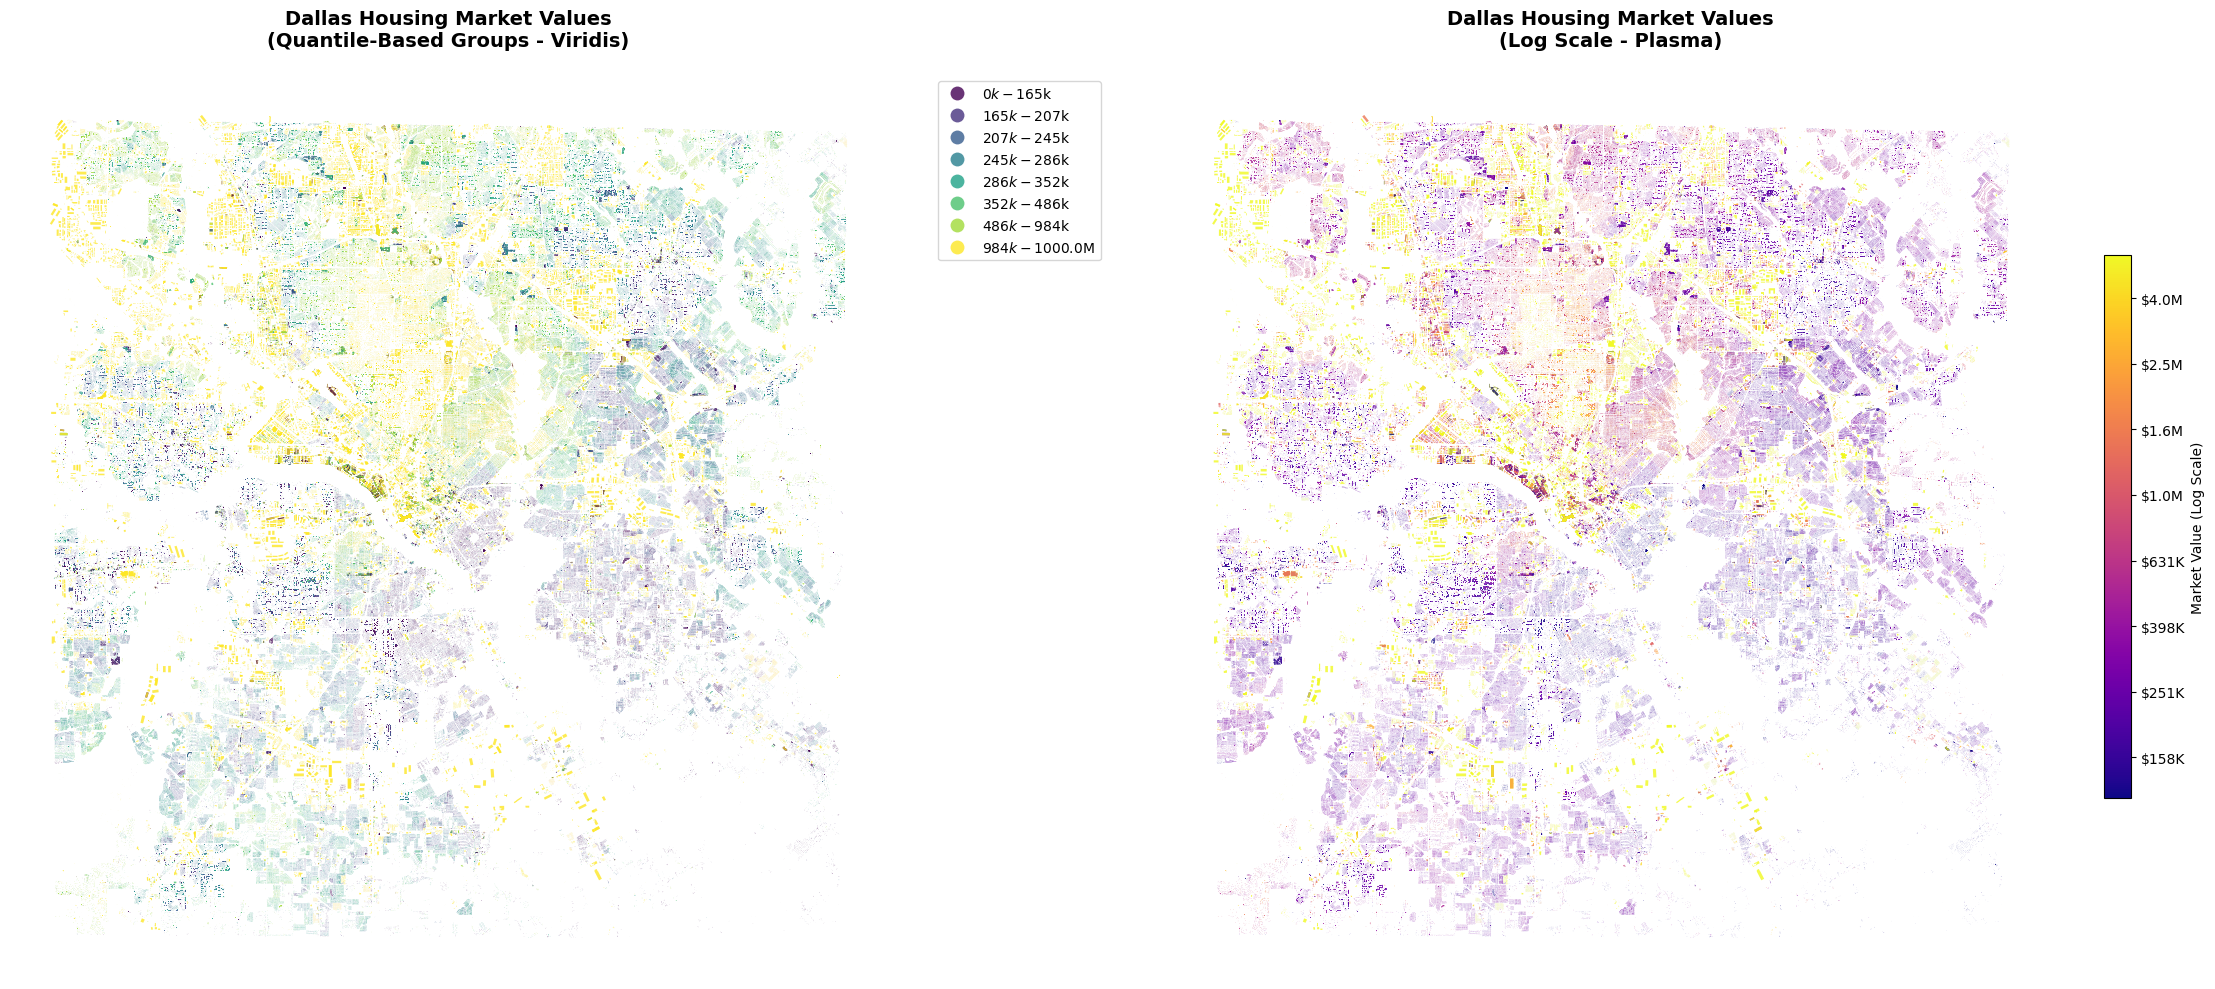


Visualization completed with 864,341 valid properties


In [26]:
import numpy as np

# Create improved market value visualization with better color distribution
print("Creating improved visualizations...")

# Remove properties with null or zero market values for cleaner visualization
dallas_valid = dallas.dropna(subset=['MKT_VALUE'])
dallas_valid = dallas_valid[dallas_valid['MKT_VALUE'] > 0]

print(f"Valid properties for visualization: {len(dallas_valid):,} (from {len(dallas):,} total)")

# Create quantile-based groups for more even distribution
def create_quantile_groups(df, n_groups=8):
    """Create market value groups based on quantiles for more even distribution"""
    
    # Calculate quantiles
    quantiles = np.linspace(0, 1, n_groups + 1)
    values = df['MKT_VALUE'].quantile(quantiles).values
    
    # Create bins and labels
    bins = values.tolist()
    labels = []
    
    for i in range(len(bins) - 1):
        start_val = bins[i]
        end_val = bins[i + 1]
        
        if start_val < 1000000:  # Less than 1M
            start_label = f"${start_val/1000:.0f}k"
        else:  # 1M or more
            start_label = f"${start_val/1000000:.1f}M"
            
        if end_val < 1000000:  # Less than 1M
            end_label = f"${end_val/1000:.0f}k"
        else:  # 1M or more
            end_label = f"${end_val/1000000:.1f}M"
        
        labels.append(f'{start_label}-{end_label}')
    
    # Create categorical column
    df['Quantile_Group'] = pd.cut(df['MKT_VALUE'], bins=bins, labels=labels, include_lowest=True)
    
    return df, bins, labels

# Apply quantile-based grouping
dallas_valid, quant_bins, quant_labels = create_quantile_groups(dallas_valid, n_groups=8)

# Print the new distribution
print("\nQuantile-based Market Value Groups:")
quant_counts = dallas_valid['Quantile_Group'].value_counts().sort_index()
for group, count in quant_counts.items():
    percentage = (count / len(dallas_valid)) * 100
    print(f"{group}: {count:,} properties ({percentage:.1f}%)")

# Create the improved visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Plot 1: Quantile-based groups with viridis colormap
dallas_valid.plot(column='Quantile_Group',
                  edgecolor='none',  # Remove edge lines for cleaner look
                  linewidth=0,
                  alpha=0.8,
                  legend=True,
                  legend_kwds={"bbox_to_anchor": (1.05, 1),
                              "loc": 'upper left',
                              "fontsize": 10},
                  ax=ax1,
                  cmap='viridis')

ax1.set_title('Dallas Housing Market Values\n(Quantile-Based Groups - Viridis)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_axis_off()

# Plot 2: Direct market value with log scale for better color distribution
# Use log transformation to compress the range
dallas_valid['log_value'] = np.log10(dallas_valid['MKT_VALUE'].clip(lower=1))

im = dallas_valid.plot(column='log_value',
                       edgecolor='none',
                       linewidth=0,
                       alpha=0.8,
                       ax=ax2,
                       cmap='plasma',
                       vmin=dallas_valid['log_value'].quantile(0.05),  # Remove extreme outliers
                       vmax=dallas_valid['log_value'].quantile(0.95))

ax2.set_title('Dallas Housing Market Values\n(Log Scale - Plasma)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_axis_off()

# Add custom colorbar for log scale
sm = plt.cm.ScalarMappable(cmap='plasma', 
                          norm=plt.Normalize(vmin=dallas_valid['log_value'].quantile(0.05), 
                                           vmax=dallas_valid['log_value'].quantile(0.95)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, shrink=0.6)
cbar.set_label('Market Value (Log Scale)', fontsize=10)

# Convert log ticks back to dollar amounts
log_ticks = cbar.get_ticks()
dollar_labels = []
for tick in log_ticks:
    value = 10**tick
    if value < 1000000:
        dollar_labels.append(f'${value/1000:.0f}K')
    else:
        dollar_labels.append(f'${value/1000000:.1f}M')
cbar.set_ticklabels(dollar_labels)

plt.tight_layout()
plt.show()

print(f"\nVisualization completed with {len(dallas_valid):,} valid properties")

Focused Market Value Groups:
Under $150k: 81,445 properties (9.4%)
$150k - $200k: 114,721 properties (13.3%)
$200k - $250k: 143,569 properties (16.6%)
$250k - $300k: 121,720 properties (14.1%)
$300k - $400k: 128,079 properties (14.8%)
$400k - $600k: 106,024 properties (12.3%)
$600k - $1M: 62,101 properties (7.2%)
Over $1M: 106,682 properties (12.3%)


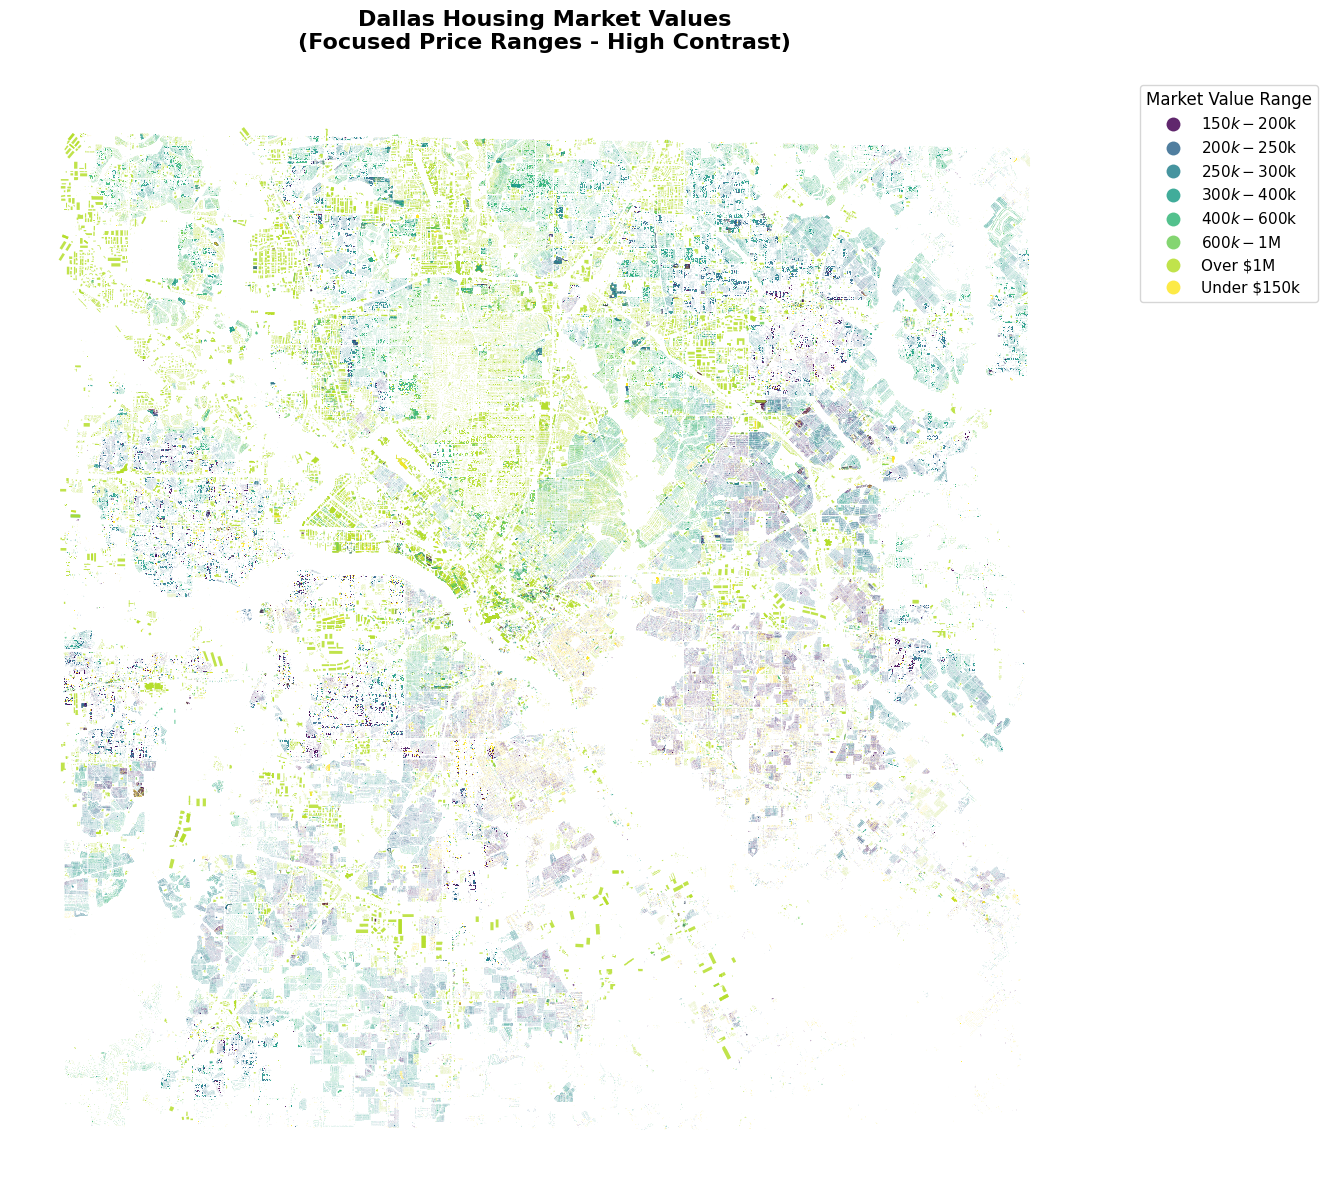


Focused visualization shows clear color differentiation across 864,341 properties


In [27]:
# Create a focused visualization on common price ranges for maximum color contrast
def create_focused_groups(df):
    """Create market value groups focused on the most common ranges"""
    
    conditions = [
        (df['MKT_VALUE'] <= 150000),
        (df['MKT_VALUE'] > 150000) & (df['MKT_VALUE'] <= 200000),
        (df['MKT_VALUE'] > 200000) & (df['MKT_VALUE'] <= 250000),
        (df['MKT_VALUE'] > 250000) & (df['MKT_VALUE'] <= 300000),
        (df['MKT_VALUE'] > 300000) & (df['MKT_VALUE'] <= 400000),
        (df['MKT_VALUE'] > 400000) & (df['MKT_VALUE'] <= 600000),
        (df['MKT_VALUE'] > 600000) & (df['MKT_VALUE'] <= 1000000),
        (df['MKT_VALUE'] > 1000000)
    ]
    
    choices = [
        'Under $150k',
        '$150k - $200k', 
        '$200k - $250k',
        '$250k - $300k',
        '$300k - $400k',
        '$400k - $600k',
        '$600k - $1M',
        'Over $1M'
    ]
    
    df['Focused_Group'] = np.select(conditions, choices, default='Unknown')
    
    return df

# Apply focused grouping
dallas_focused = create_focused_groups(dallas_valid.copy())

# Print distribution
print("Focused Market Value Groups:")
focused_counts = dallas_focused['Focused_Group'].value_counts()
# Sort by the logical order
group_order = ['Under $150k', '$150k - $200k', '$200k - $250k', '$250k - $300k', 
               '$300k - $400k', '$400k - $600k', '$600k - $1M', 'Over $1M']
for group in group_order:
    if group in focused_counts:
        count = focused_counts[group]
        percentage = (count / len(dallas_focused)) * 100
        print(f"{group}: {count:,} properties ({percentage:.1f}%)")

# Create the focused visualization with high contrast colors
fig, ax = plt.subplots(figsize=(18, 12))

# Use a custom colormap with high contrast
from matplotlib.colors import ListedColormap
colors = ['#440154', '#31688e', '#26828e', '#1f9e89', '#35b779', 
          '#6ece58', '#b5de2b', '#fde725']
custom_cmap = ListedColormap(colors)

dallas_focused.plot(column='Focused_Group',
                    edgecolor='none',
                    linewidth=0,
                    alpha=0.85,
                    legend=True,
                    legend_kwds={"bbox_to_anchor": (1.05, 1),
                                "loc": 'upper left',
                                "fontsize": 11,
                                "title": "Market Value Range",
                                "title_fontsize": 12},
                    ax=ax,
                    cmap=custom_cmap,
                    categorical=True)

ax.set_title('Dallas Housing Market Values\n(Focused Price Ranges - High Contrast)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()

print(f"\nFocused visualization shows clear color differentiation across {len(dallas_focused):,} properties")